In [1]:
import re
import numpy as np
import pandas as pd
import time
from random import random,randint
import matplotlib.pyplot as plt
import seaborn as sbn
import scipy.stats as st
from difflib import SequenceMatcher, get_close_matches

In [2]:
!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Market Shares

In [ ]:
mkt_sh = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/market_shares.csv")
print(mkt_sh.shape)

(4, 4)


In [ ]:
mkt_sh_long = pd.melt(mkt_sh, id_vars=['year'], value_vars=['MercadoLibre',	'Amazon',	'Walmart Mexico (Walmex)'])

In [ ]:
mkt_sh_long.columns = ['Year', 'Platform', 'value']

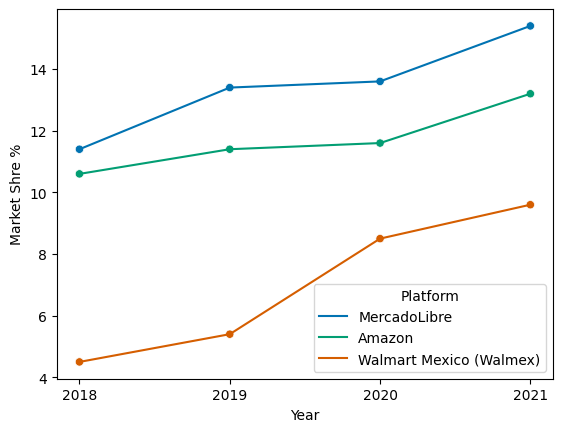

In [ ]:
sbn.lineplot(mkt_sh_long, x = 'Year', y = 'value', hue = 'Platform').set(ylabel ='Market Shre %')
sbn.scatterplot(mkt_sh_long, x = 'Year', y = 'value', hue = 'Platform', legend = False).set_xticks(ticks = range(2018,2022), labels=range(2018, 2022))
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/mkt_sh.png')
plt.show()

In [ ]:
for i in mkt_sh.year:
  print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


## Read Amazon and Mercado Libre Data

In [ ]:
data_meli = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_3.csv")
print(data_meli.shape)
for i in range(4,14):
  data_meli = pd.concat([data_meli, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_"+str(i)+".csv")])
  print(data_meli.shape)
data_meli.drop('Unnamed: 0', axis = 1, inplace = True)
data_meli.reset_index(drop = True, inplace = True)
data_meli["platform"] = "Mercado Libre"

(457, 23)
(929, 23)
(1404, 23)
(1877, 23)
(2347, 23)
(2817, 23)
(3293, 23)
(3754, 23)
(4232, 23)
(4721, 23)
(5209, 23)


In [ ]:
data_meli.loc[0]

link             https://click1.mercadolibre.com.mx/mclics/clic...
title            Bocinas Bluetooth Portatil Altavoz Recargables...
n_reviews                                                       38
n_stars                                                        4.8
l_tree                                                           3
categories       ['Electrónica, Audio y Video', 'Audio', 'Bocin...
stock                                                           17
new                                                           True
sales_1                                              +100 vendidos
recommended                                                      0
free_delivery                                                 True
seller_name                                                    NaN
seller_link              https://perfil.mercadolibre.com.mx/EMUAEL
seller_sales                                                +10mil
ch_vec                                                        

In [ ]:
data_amazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all.csv")
print(data_amazon.shape)
for i in range(2,12):
  data_amazon = pd.concat([data_amazon, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all_"+str(i)+".csv")]).reset_index(drop = True)
  print(data_amazon.shape)
data_amazon["platform"] = "Amazon"

(379, 11)
(760, 11)
(1137, 11)
(1513, 11)
(1889, 11)
(2264, 11)
(2642, 11)
(3031, 11)
(3428, 11)
(3827, 11)
(4231, 11)


In [ ]:
data_amazon.loc[0]

page                                                             1
rank                                                             1
title                   JBL Flip 6 Bocina Portátil Bluetooth Negro
link             /JBL-Bocina-Port%C3%A1til-Bluetooth-Negro/dp/B...
n_stars                                                        4.8
n_reviews                                                   6408.0
curr_price                                                  1852.0
fast_delivery                                                 True
prime                                                         True
free_delivery                                                 True
date                                                      20230706
platform                                                    Amazon
Name: 0, dtype: object

In [ ]:
data_amazon.date.unique()

array([20230706, 20230707, 20230708, 20230710, 20230711, 20230713,
       20230718, 20230724, 20230726, 20230727, 20230803])

In [ ]:
data_meli.date.unique()

array([20230706, 20230707, 20230708, 20230710, 20230711, 20230713,
       20230718, 20230724, 20230726, 20230727, 20230803])

## Data transformation

In [ ]:
#Get dummies for benefits
meli_benefits = []
for ben_vec in data_meli.benefits:
  for benefit in re.sub("[\[\]'.]", "", ben_vec).split(","):
    meli_benefits.append(benefit.strip())
meli_benefits = list(set(meli_benefits))
data_meli["devolucion_gratis"] = data_meli["benefits"].apply(lambda x: meli_benefits[0] in x)
data_meli["mercado_puntos"] = data_meli["benefits"].apply(lambda x: meli_benefits[1] in x)
data_meli["compra_protegida"] = data_meli["benefits"].apply(lambda x: meli_benefits[2] in x)

In [ ]:
#Get dummies for some characteristics

data_meli["bluetooth"] = data_meli["ch_vec"].apply(lambda x: "bluetooth" in x)
data_meli["usb_c"] = data_meli["ch_vec"].apply(lambda x: "USB-C" in x)
data_meli["bateria_recargable"] = data_meli["ch_vec"].apply(lambda x: "Batería recargable" in x)
data_meli["woofer"] = data_meli["ch_vec"].apply(lambda x: "woofer" in x)
data_meli["radio"] = data_meli["ch_vec"].apply(lambda x: "radio" in x)
data_meli["portatil"] = data_meli["ch_vec"].apply(lambda x: "portatil" in x)

In [ ]:
#Power in watts
potencia = []
for ch in data_meli.ch_vec:
  if "Potencia de" in ch:
    potencia.append(float(ch[ch.find("Potencia de")+12:ch.find("W.")]))
  else:
    potencia.append(0)
data_meli["potencia_w"] = potencia

In [ ]:
data_amazon["title"] = data_amazon["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))
data_meli["title"] = data_meli["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))

data_amazon["bluetooth"] = data_amazon["title"].apply(lambda x: ("bluetooth" in x))
data_amazon["bateria_recargable"] = data_amazon["title"].apply(lambda x: ("bateria" in x))
data_amazon["portatil"] = data_amazon["title"].apply(lambda x: ("portatil" in x))

In [ ]:
data_meli["bluetooth"] = data_meli["title"].apply(lambda x: ("bluetooth" in x))
data_meli["bateria_recargable"] = data_meli["title"].apply(lambda x: ("bateria" in x))
data_meli["portatil"] = data_meli["title"].apply(lambda x: ("portatil" in x))

In [ ]:
brands = ["sony", "alexa", "amazon", "jbl", "bose", "yamaha", "lg", "echo", "kaiser", "logitech", "tlc", "sonos", "hisense", "samsung", "xiaomi"]
data_meli["known_brand"] = data_meli.title.apply(lambda x: any([br in x for br in brands]))
data_amazon["known_brand"] = data_amazon.title.apply(lambda x: any([br in x for br in brands]))

In [ ]:
dates = data_meli.date.unique()

In [ ]:
for k in range(len(dates)):
  print('Start of k = ', k)
  data_meli_fil = data_meli[data_meli.date == dates[k]]
  data_amazon_fil = data_amazon[data_amazon.date == dates[k]]
  M = []
  for or_ti in data_meli_fil.title:
    l = data_amazon_fil.title.apply(lambda x: fuzz.partial_ratio(x, or_ti))
    M.append(l)
  M = np.matrix(M)
  data_meli_fil['score'] = M.max(axis = 1).T.tolist()[0]
  ind_meli = data_amazon_fil.index[M.argmax(axis = 1).T.tolist()[0]]
  data_meli_fil['index_sim'] = ind_meli
  data_meli_fil['title_sim'] = data_amazon_fil.title[ind_meli].values

  data_amazon_fil['score'] = M.max(axis = 0).tolist()[0]
  ind_amazon = data_meli_fil.index[M.argmax(axis = 0).tolist()[0]]
  data_amazon_fil['index_sim'] = ind_amazon.values
  data_amazon_fil['title_sim'] = data_meli_fil.title[ind_amazon].values

  data_amazon_fil.to_csv('/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_'+str(k+1)+'.csv',index=False)
  data_meli_fil.to_csv('/content/drive/MyDrive/Colab Notebooks/data/data_meli/meli_'+str(k+1)+'.csv',index=False)

  print('Endo of k = ', k, '\n')

## Reading Transformed data and merging

In [4]:
data_meli = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/meli_1.csv")
print(data_meli.shape)
for i in range(2,12):
  data_meli = pd.concat([data_meli, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/meli_"+str(i)+".csv")])
  print(data_meli.shape)
data_meli.reset_index(drop = True, inplace = True)

(457, 36)
(929, 36)
(1404, 36)
(1877, 36)
(2347, 36)
(2817, 36)
(3293, 36)
(3754, 36)
(4232, 36)
(4721, 36)
(5209, 36)


In [5]:
data_amazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_1.csv")
print(data_amazon.shape)
for i in range(2,12):
  data_amazon = pd.concat([data_amazon, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_"+str(i)+".csv")]).reset_index(drop = True)
  print(data_amazon.shape)

(379, 18)
(760, 18)
(1137, 18)
(1513, 18)
(1889, 18)
(2264, 18)
(2642, 18)
(3031, 18)
(3428, 18)
(3827, 18)
(4231, 18)


In [6]:
brands = ["sony", "alexa", "amazon", "jbl", "bose", "yamaha", "lg", "echo", "kaiser", "logitech", "tlc", "sonos", "hisense", "samsung", "xiaomi"]
data_meli["known_brand"] = data_meli.title.apply(lambda x: any([br in x for br in brands]))
data_amazon["known_brand"] = data_amazon.title.apply(lambda x: any([br in x for br in brands]))

data_meli['price_sim'] = data_amazon.curr_price.loc[data_meli.index_sim].reset_index(drop = True)
data_amazon['price_sim'] = data_meli.curr_price.loc[data_amazon.index_sim].reset_index(drop = True)

In [7]:
cols_in_common = ['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth','bateria_recargable', 'portatil', 'date',
       'score', 'index_sim', 'title_sim', 'known_brand', 'price_sim']
data_all = pd.concat([data_meli[cols_in_common], data_amazon[cols_in_common]]).reset_index(drop = True)

In [8]:
data_all['multi_home'] = data_all.score >= 85

In [ ]:
for var, obs in data_amazon.loc[2].items():
  print(var, " & ", obs, " \\\\")

page  &  1  \\
rank  &  3  \\
title  &  ultimate ears wonderboom 2 bocina inalambrica, bluetooth, sonido envolvente de 360°, resistente al agua ip67, conexion de 2 altavoces para sonido potente, bateria de 13 h - roja  \\
link  &  /Ultimate-Ears-Wonder-Boom-Rojo/dp/B07YYZW959/ref=sr_1_3?__mk_es_MX=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=21ZO1CHSPRT06&keywords=bocina&qid=1688679491&sprefix=bocina%2Caps%2C177&sr=8-3  \\
n_stars  &  4.9  \\
n_reviews  &  5322.0  \\
curr_price  &  1315.0  \\
fast_delivery  &  True  \\
prime  &  True  \\
free_delivery  &  True  \\
date  &  20230706  \\
platform  &  Amazon  \\
bluetooth  &  True  \\
bateria_recargable  &  True  \\
portatil  &  False  \\


In [ ]:
data_all.groupby(by = ["platform"]).describe().transpose()

In [ ]:
data_aux = data_all.groupby(by = ["title", "platform","date"]).count()
data_aux[data_aux.page >1].shape

(927, 11)

In [ ]:
data_all = data_all.drop_duplicates(subset = ['title','platform','date'])

In [ ]:
data_aux = data_all.groupby(by = ["title","platform"]).count()
data_aux[data_aux.page<4]

## Data cleaning

In [9]:
data_all = data_all[data_all.curr_price<data_all.curr_price.quantile(0.9)]

In [10]:
data_meli = data_meli[data_meli.curr_price<data_meli.curr_price.quantile(0.9)]

In [11]:
data_amazon = data_amazon[data_amazon.curr_price<data_amazon.curr_price.quantile(0.9)]

## Data Visualization

### Single variable exploration

In [ ]:
sbn.set_palette("colorblind6")

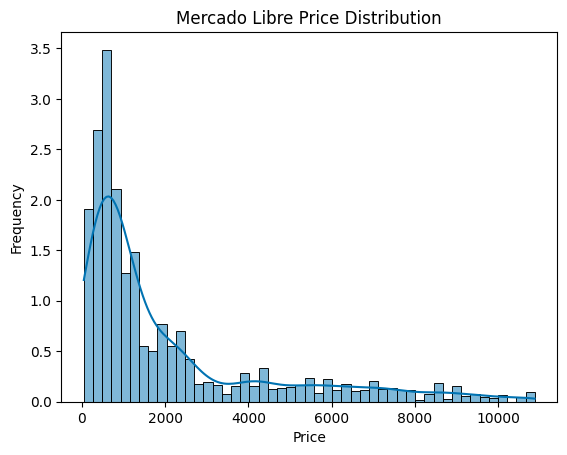

In [ ]:
fig1 = sbn.histplot(data_meli, x = "curr_price", stat = "frequency", kde = True)
fig1.set(title='Mercado Libre Price Distribution', xlabel = "Price")
plt.show()

<Axes: title={'center': 'Mercado Libre Sales'}, xlabel='Sales', ylabel='count'>

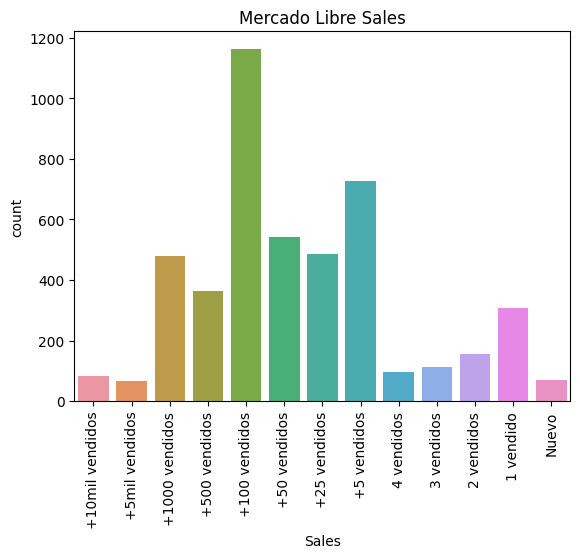

In [ ]:
fig2 = sbn.countplot(data_meli, x = "sales_1", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig2.set(title='Mercado Libre Sales', xlabel = "Sales")
fig2.tick_params(axis='x', rotation=90)
fig2

<Axes: title={'center': 'Mercado Libre Stock Distribution'}, xlabel='Stock', ylabel='Frequency'>

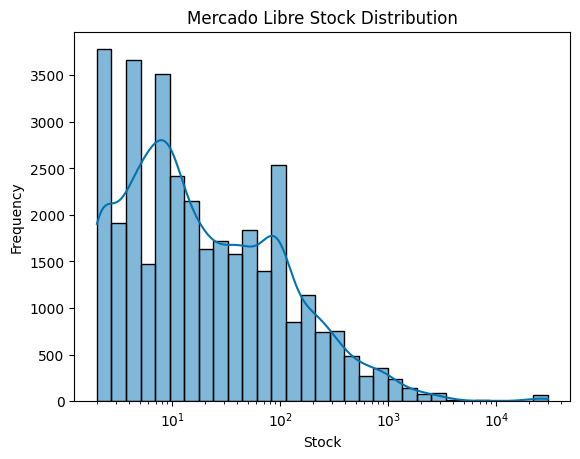

In [ ]:
fig3 = sbn.histplot(data_meli, x = "stock", stat = "frequency", kde = True, log_scale=True)
fig3.set(title='Mercado Libre Stock Distribution', xlabel = "Stock")
fig3

<Axes: title={'center': 'Mercado Libre Stock Distribution - Truncated'}, xlabel='Stock', ylabel='Frequency'>

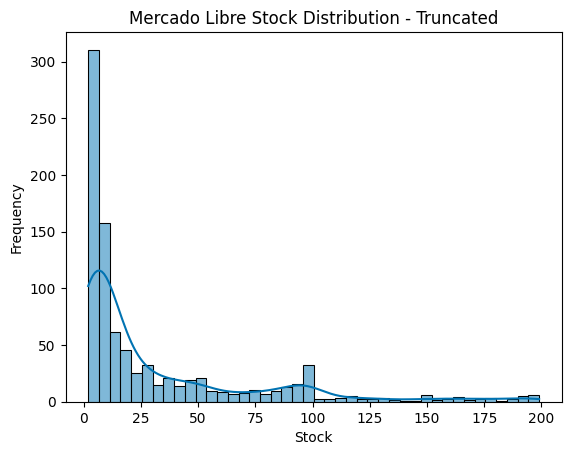

In [ ]:
fig4 = sbn.histplot(data_meli[data_meli.stock <200], x = "stock", stat = "frequency", kde = True)
fig4.set(title='Mercado Libre Stock Distribution - Truncated', xlabel = "Stock")
fig4

<Axes: title={'center': 'Consumption (W) distribution'}, xlabel='Consumption', ylabel='Frequency'>

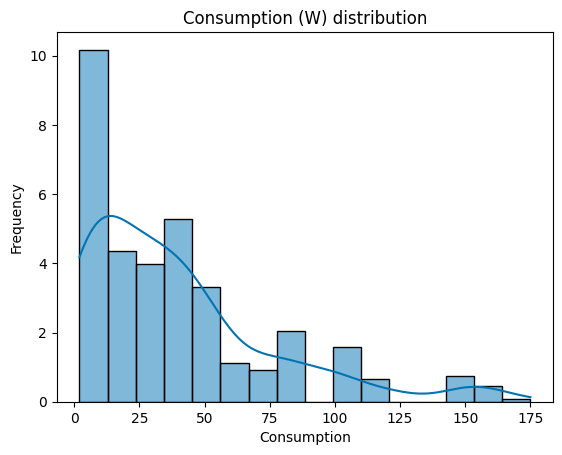

In [ ]:
fig5 = sbn.histplot(data_meli[(data_meli.potencia_w>0) & (data_meli.potencia_w<200) ], x = "potencia_w", stat = "frequency", kde = True)
fig5.set(title='Consumption (W) distribution', xlabel = "Consumption")
fig5

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

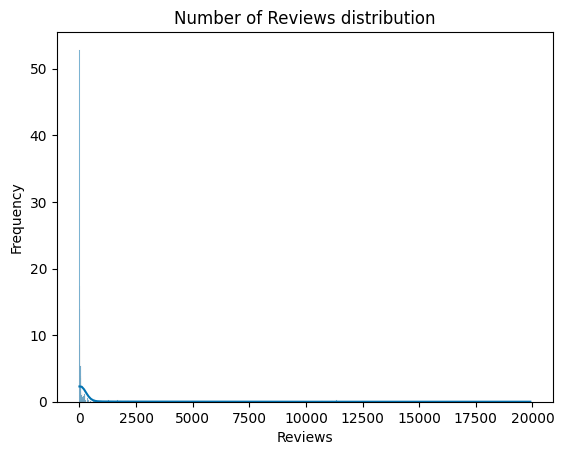

In [ ]:
fig6 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", kde = True)
fig6.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig6

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

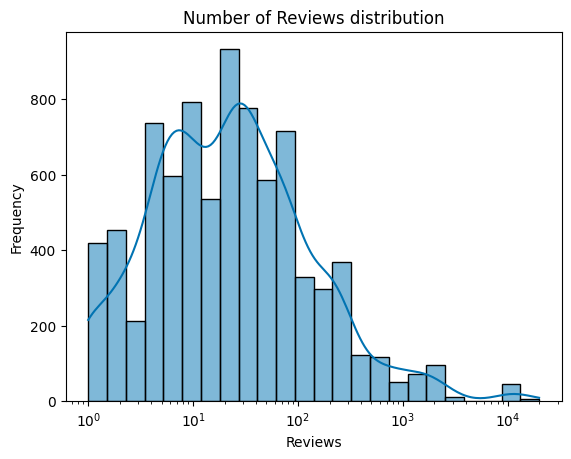

In [ ]:
fig7 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", log_scale = True, kde = True)
fig7.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig7

<Axes: title={'center': 'Mercado Libre Product Rating'}, xlabel='Rating', ylabel='Frequency'>

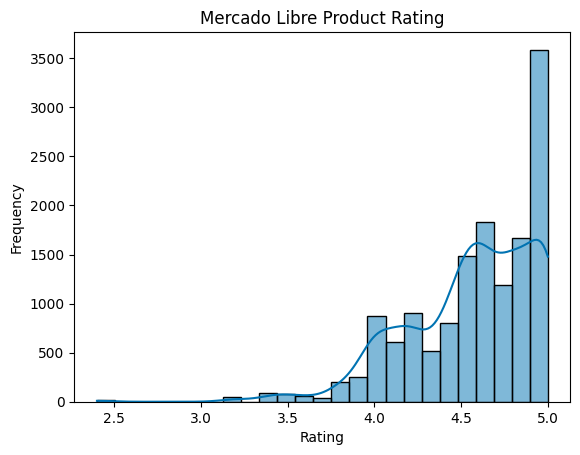

In [ ]:
fig8 = sbn.histplot(data_meli[data_meli.n_stars>0], x = "n_stars", stat = "frequency", kde = True)
fig8.set(title='Mercado Libre Product Rating', xlabel = "Rating")
fig8

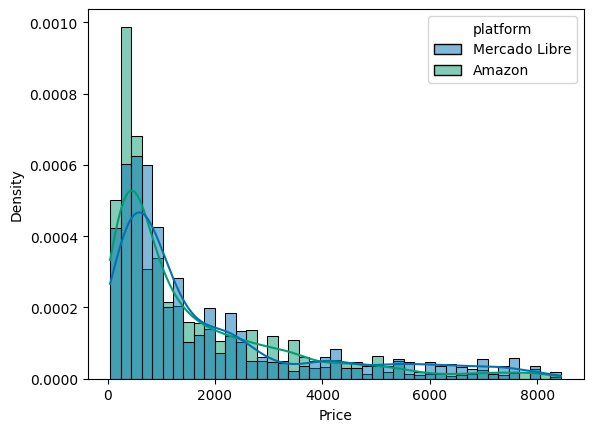

In [ ]:
fig_all1 = sbn.histplot(data_all, x = "curr_price", stat = "density", hue= "platform", kde = True, common_norm = False)
fig_all1.set(xlabel = "Price")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/price_dist.png')
plt.show()

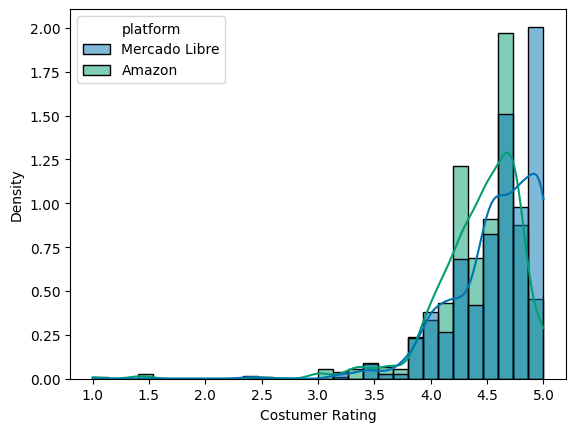

In [ ]:
fig_all2 = sbn.histplot(data_all[data_all.n_reviews > 0], x = "n_stars", stat = "density", hue= "platform", kde = True, common_norm = False, bins = 30)
fig_all2.set( xlabel = "Costumer Rating")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rating_dist.png')
plt.show()

<Axes: title={'center': 'Review Count Distribution'}, xlabel='Review Count', ylabel='Frequency'>

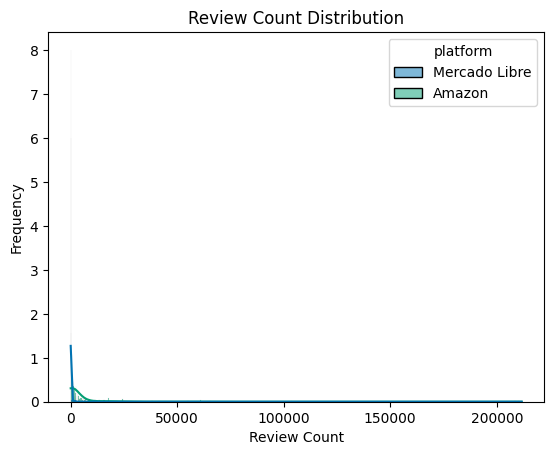

In [ ]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False)
fig_all3.set(title='Review Count Distribution', xlabel = "Review Count")
fig_all3

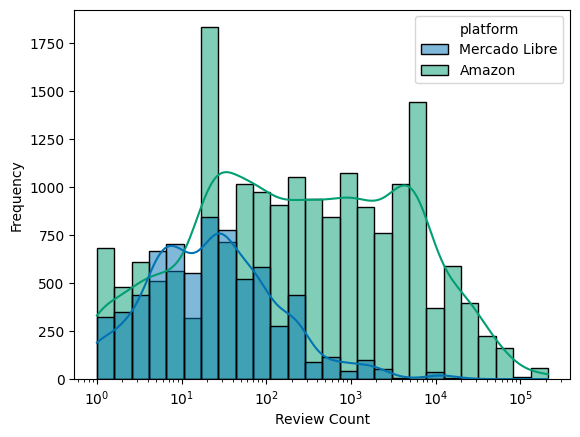

In [ ]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False, log_scale = True)
fig_all3.set( xlabel = "Review Count")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rev_count_dist.png')
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


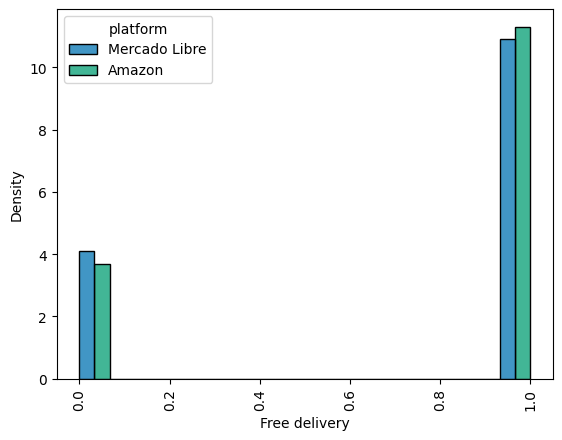

In [ ]:
fig_all4 = sbn.histplot(data_all, x = "free_delivery", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all4.set(xlabel = "Free delivery")
fig_all4.tick_params(axis='x', rotation=90)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_dist.png')
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


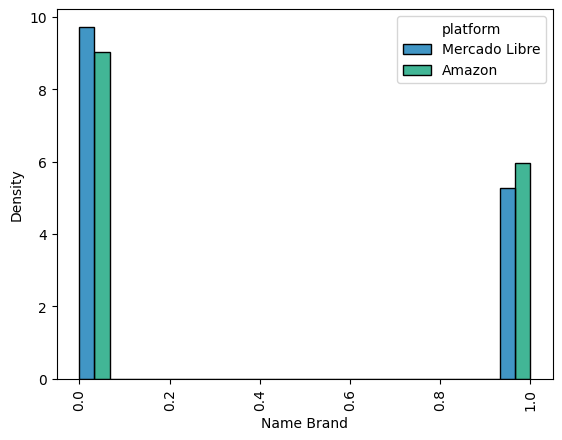

In [ ]:
fig_all5 = sbn.histplot(data_all, x = "known_brand", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all5.set(xlabel = "Name Brand")
fig_all5.tick_params(axis='x', rotation=90)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_dist.png')
plt.show()

### Interaction Visualization

<Axes: title={'center': 'Mercado Libre Sales vs Price'}, xlabel='Sales', ylabel='Price'>

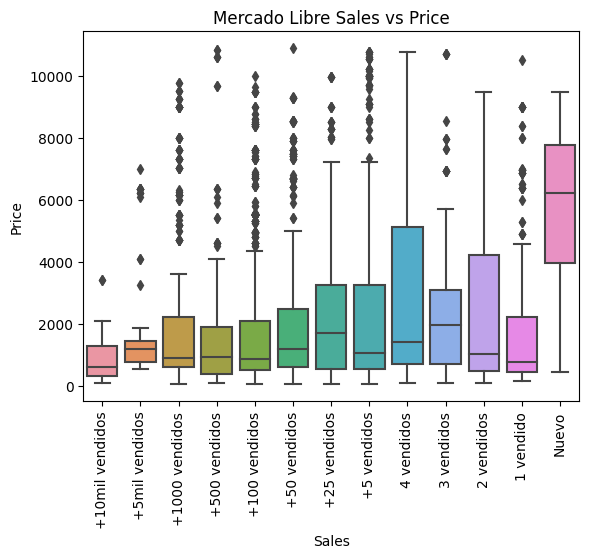

In [ ]:
fig9 = sbn.boxplot(data_meli, x = "sales_1", y = "curr_price", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig9.set(title='Mercado Libre Sales vs Price', xlabel = "Sales", ylabel = "Price")
fig9.tick_params(axis='x', rotation=90)
fig9

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

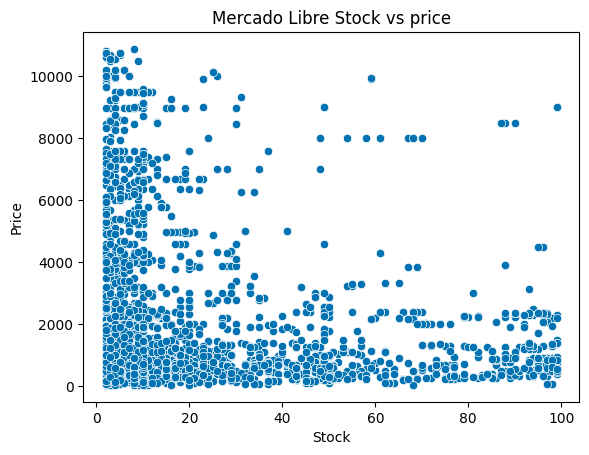

In [ ]:
fig10 = sbn.scatterplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price")
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

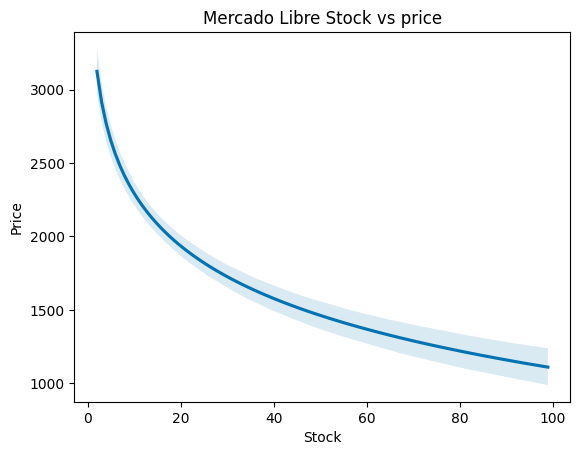

In [ ]:
fig10 = sbn.regplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price", logx = True, scatter = False)
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre New vs Used Prices'}, xlabel='New', ylabel='Price'>

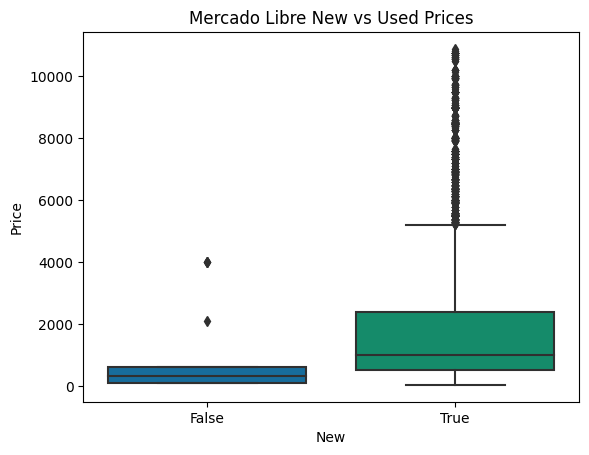

In [ ]:
fig11 = sbn.boxplot(data_meli, x = "new", y = "curr_price")
fig11.set(title='Mercado Libre New vs Used Prices', xlabel = "New", ylabel = "Price")
fig11

<Axes: title={'center': 'Mercado Libre Recomended Product Prices'}, xlabel='Recommended', ylabel='Price'>

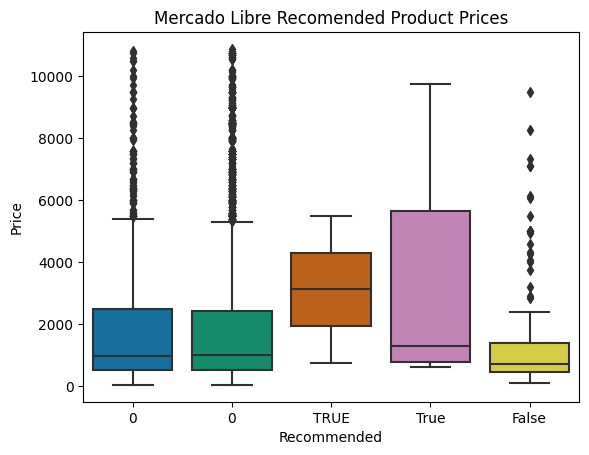

In [ ]:
fig12 = sbn.boxplot(data_meli, x = "recommended", y = "curr_price")
fig12.set(title='Mercado Libre Recomended Product Prices', xlabel = "Recommended", ylabel = "Price")
fig12

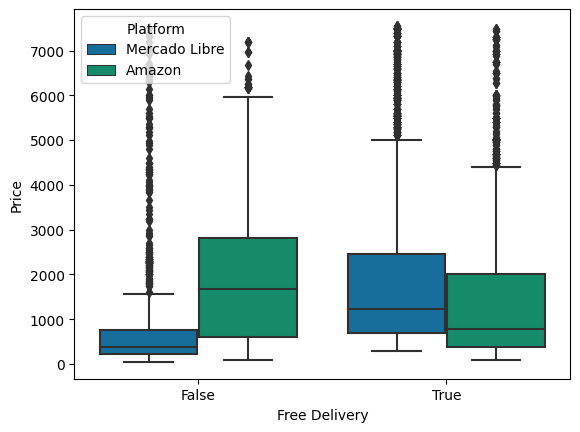

In [ ]:
fig13 = sbn.boxplot(data_all, x = "free_delivery", y = "curr_price", hue = "platform")
fig13.set(xlabel = "Free Delivery", ylabel = "Price")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_prices_boxplot.png')
plt.show()

In [ ]:
data_all.columns

Index(['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth', 'bateria_recargable',
       'portatil', 'date', 'known_brand'],
      dtype='object')

<Axes: title={'center': 'Mercado Libre Free vs Costly Returns Prices'}, xlabel='Free returns', ylabel='Price'>

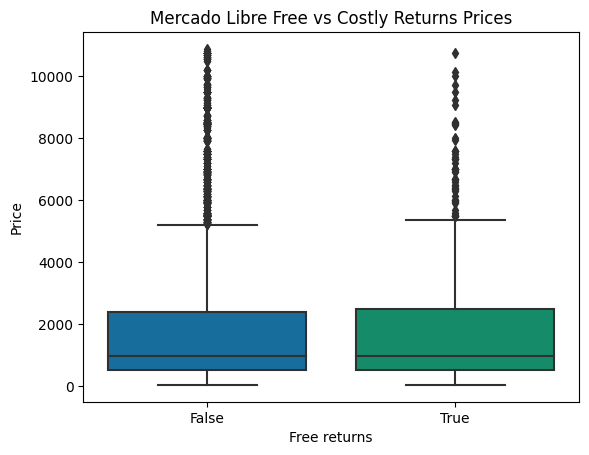

In [ ]:
fig14 = sbn.boxplot(data_meli, x = "devolucion_gratis", y = "curr_price")
fig14.set(title='Mercado Libre Free vs Costly Returns Prices', xlabel = "Free returns", ylabel = "Price")
fig14

<Axes: title={'center': 'Amazon Price Distribution'}, xlabel='Price', ylabel='Frequency'>

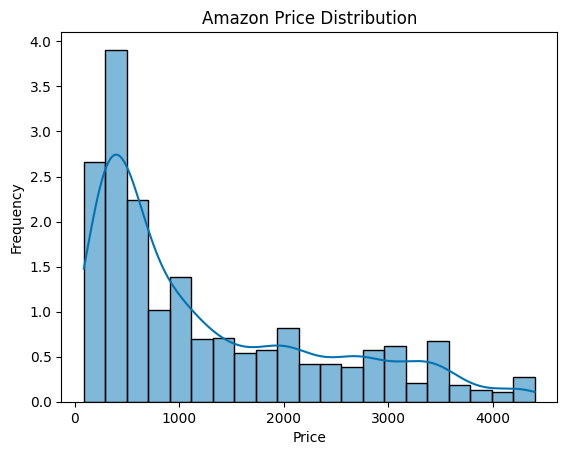

In [ ]:
fig2 = sbn.histplot(data_amazon, x = "curr_price", stat = "frequency", kde = True)
fig2.set(title='Amazon Price Distribution', xlabel = "Price")
fig2

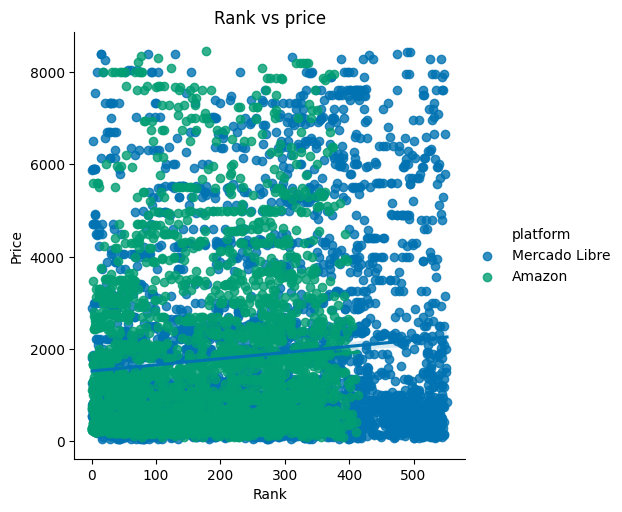

In [ ]:
fig_all5 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform")
fig_all5.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all5

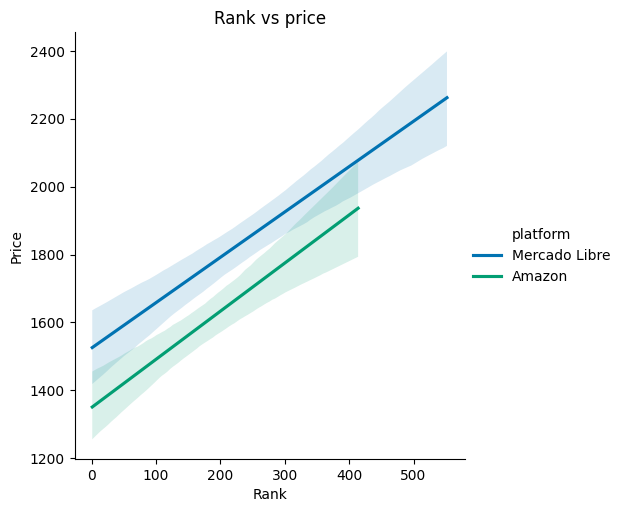

In [ ]:
fig_all6 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform", scatter = False)
fig_all6.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all6

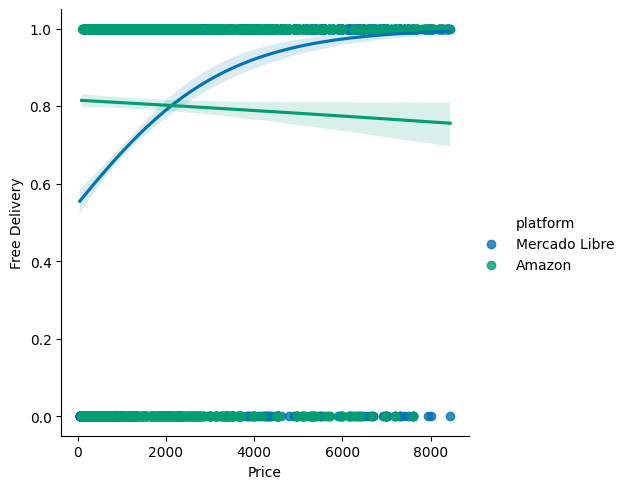

In [ ]:
fig_all5 = sbn.lmplot(data_all, x = "curr_price", y = "free_delivery", hue = "platform", logistic = True)
fig_all5.set(xlabel = "Price", ylabel = "Free Delivery")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_price.png')
plt.show()

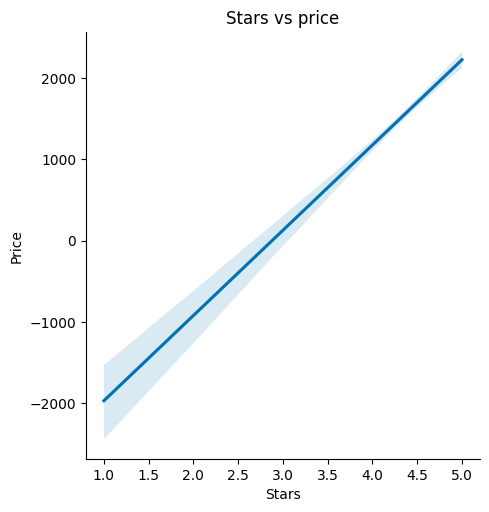

In [ ]:
fig_all6 = sbn.lmplot(data_all[data_all.n_reviews > 0 ], x = "n_stars", y = "curr_price", scatter = False)
fig_all6.set(title='Stars vs price', xlabel = "Stars", ylabel = "Price")
plt.show()

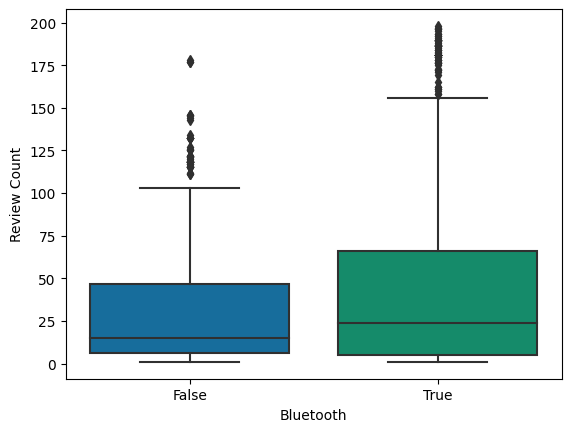

In [ ]:
fig14 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "bluetooth", y = "n_reviews")
fig14.set(xlabel = "Bluetooth", ylabel = "Review Count")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rev_boxplot.png')
plt.show()

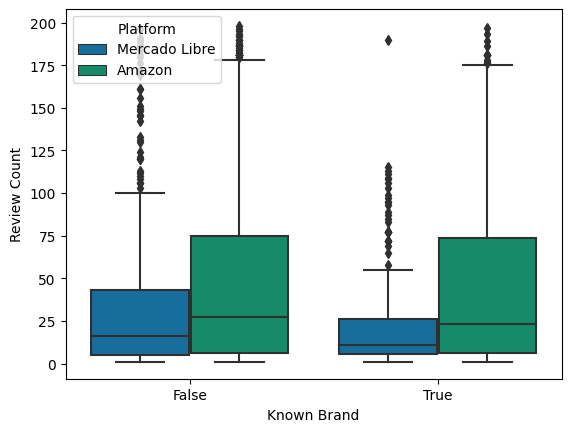

In [ ]:
fig14 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "known_brand", y = "n_reviews", hue = "platform")
fig14.set(xlabel = "Known Brand", ylabel = "Review Count")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

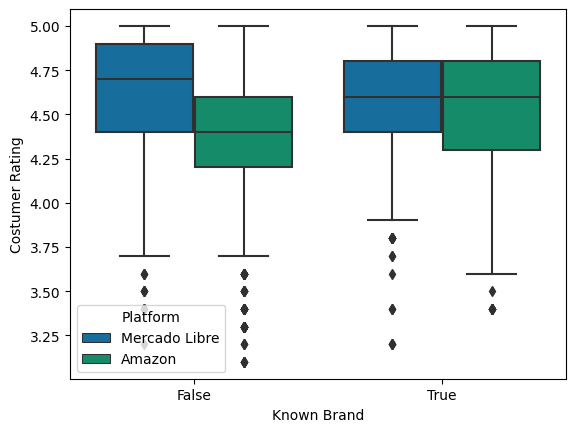

In [ ]:
fig14 = sbn.boxplot(data_all[data_all.n_stars > 3], x = "known_brand", y = "n_stars", hue = "platform")
fig14.set(xlabel = "Known Brand", ylabel = "Costumer Rating")
plt.legend(loc='lower left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rat_boxplot.png')
plt.show()

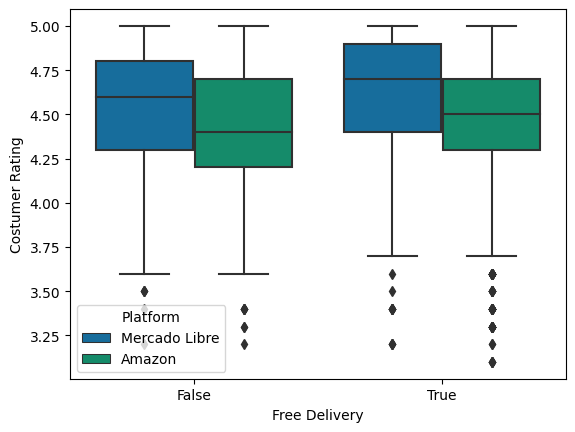

In [ ]:
fig14 = sbn.boxplot(data_all[data_all.n_stars > 3], x = "free_delivery", y = "n_stars", hue = "platform")
fig14.set(xlabel = "Free Delivery", ylabel = "Costumer Rating")
plt.legend(loc='lower left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_rat_boxplot.png')
plt.show()

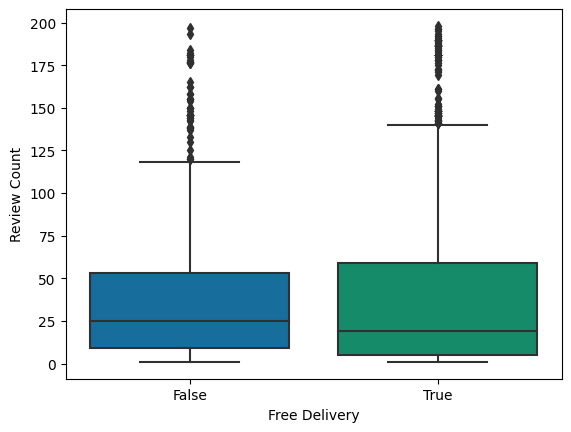

In [ ]:
fig15 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "free_delivery", y = "n_reviews")
fig15.set(xlabel = "Free Delivery", ylabel = "Review Count")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

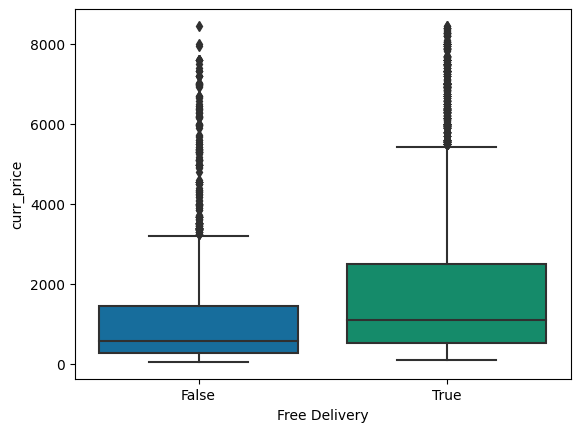

In [ ]:
fig15 = sbn.boxplot(data_all, x = "free_delivery", y = "curr_price")
fig15.set(xlabel = "Free Delivery", ylabel = "curr_price")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

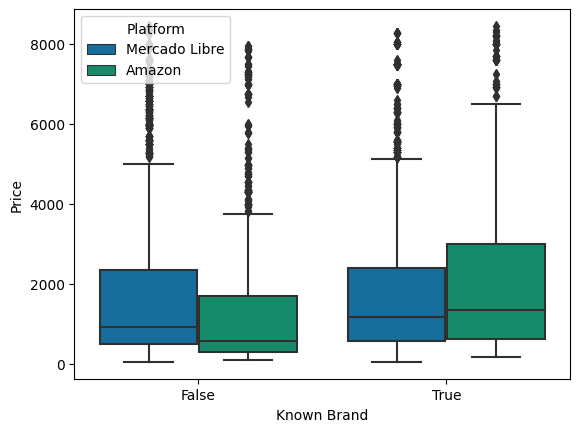

In [ ]:
fig15 = sbn.boxplot(data_all, x = "known_brand", y = "curr_price", hue = "platform")
fig15.set(xlabel = "Known Brand", ylabel = "Price")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_price_boxplot.png')
plt.show()

In [ ]:
data_all[data_all.multi_home == True][['platform','title', 'title_sim']].loc[110]

platform                                         Mercado Libre
title        bocina harman kardon onyx studio 8 portatil bl...
title_sim                          harman kardon onyx studio 8
Name: 110, dtype: object

In [ ]:
data_all.loc[110].title_sim

'harman kardon onyx studio 8'

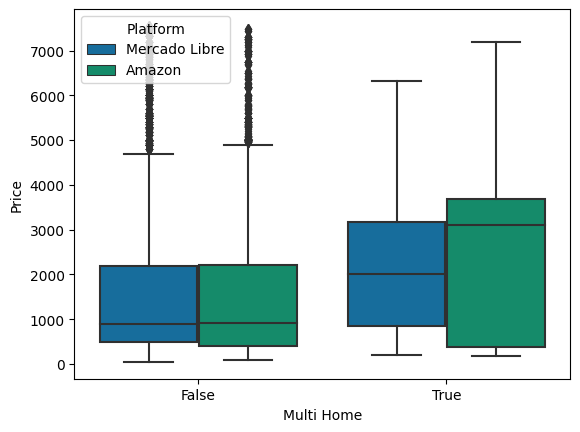

In [ ]:
fig16 = sbn.boxplot(data_all, x = "multi_home", y = "curr_price", hue = "platform")
fig16.set(xlabel = "Multi Home", ylabel = "Price")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/multihome_price_boxplot.png')
plt.show()

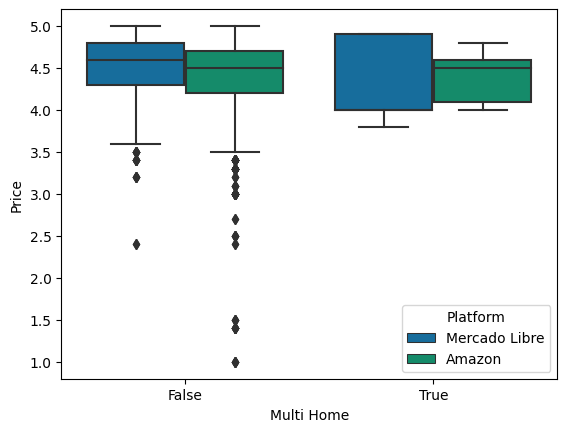

In [ ]:
fig16 = sbn.boxplot(data_all[data_all.n_reviews > 0], x = "multi_home", y = "n_stars", hue = "platform")
fig16.set(xlabel = "Multi Home", ylabel = "Price")
plt.legend(loc='lower right', title='Platform')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_price_boxplot.png')
plt.show()

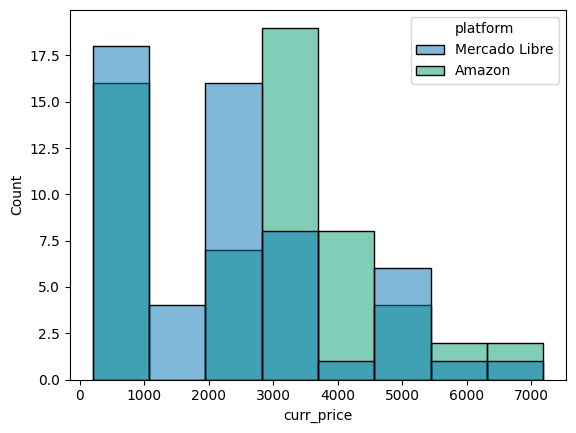

In [ ]:
fig17 = sbn.histplot(data_all[data_all.multi_home == True], x = "curr_price", hue = "platform")
plt.show()

In [ ]:
data_all.multi_home.sum()/data_all.shape[0]*100

1.3303508358841536

In [ ]:
data_meli_mult = data_meli[data_meli.score >= 90]
data_meli_mult["price_dif"] = (data_meli_mult.curr_price - data_meli_mult.price_sim)
data_meli_mult.price_dif.describe()

<ipython-input-82-2e2aa84d845e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_meli_mult["price_dif"] = data_meli_mult.curr_price - data_meli_mult.price_sim


count      45.000000
mean      303.155556
std       864.594518
min     -1388.000000
25%      -335.000000
50%       251.000000
75%       630.000000
max      2925.000000
Name: price_dif, dtype: float64

<Axes: xlabel='price_dif', ylabel='Count'>

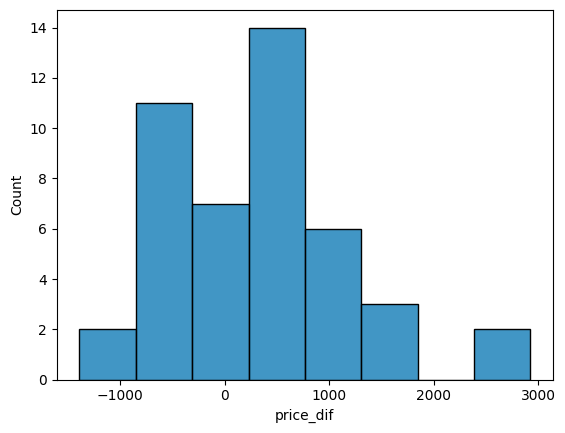

In [ ]:
sbn.histplot(x = data_meli_mult.price_dif)

In [ ]:
data_all.bluetooth = data_all.bluetooth.astype(float)
data_all.known_brand = data_all.known_brand.astype(float)
data_all.free_delivery = data_all.free_delivery.astype(float)

In [ ]:
data_meli.bluetooth = data_meli.bluetooth.astype(float)
data_meli.free_delivery = data_meli.free_delivery.astype(float)

In [ ]:
data_amazon.bluetooth = data_amazon.bluetooth.astype(float)
data_amazon.free_delivery = data_amazon.free_delivery.astype(float)

In [ ]:
cols = ['n_stars', 'n_reviews', 'curr_price',
          'free_delivery', 'platform', 'bluetooth', 'known_brand']
for col in cols:
  if col != 'platform':
    print(col, data_all[cols].groupby(by = "platform").describe()[col])

n_stars                 count      mean       std  min  25%  50%  75%  max
platform                                                          
Amazon         3153.0  4.154964  1.136852  0.0  4.2  4.5  4.7  5.0
Mercado Libre  3868.0  1.210962  2.027804  0.0  0.0  0.0  3.9  5.0
n_reviews                 count         mean           std  min   25%    50%     75%  \
platform                                                                     
Amazon         3153.0  4028.447827  14687.485012  0.0  24.0  248.0  1989.0   
Mercado Libre  3868.0    52.348501    619.977091  0.0   0.0    0.0     1.0   

                    max  
platform                 
Amazon         211668.0  
Mercado Libre   19907.0  
curr_price                 count         mean          std   min    25%    50%      75%  \
platform                                                                       
Amazon         3153.0  1603.424675  1727.688613  89.0  395.0  899.0  2279.00   
Mercado Libre  3868.0  1870.932782  2002.97489

In [ ]:
data_aux_meli = data_meli[data_meli.n_reviews > 0]
data_aux_amazon = data_amazon[data_amazon.n_reviews > 0]
print(st.ttest_ind(data_aux_meli.n_stars,data_aux_amazon.n_stars, equal_var = False).pvalue)
print(st.ttest_ind(data_aux_meli.n_reviews,data_aux_amazon.n_reviews, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.curr_price,data_amazon.curr_price, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.free_delivery,data_amazon.free_delivery, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.bluetooth,data_amazon.bluetooth, equal_var = False).pvalue)

1.485491363463857e-46
9.331107124068579e-57
1.1315836454920029e-89
0.08008471535537233
4.7904062959413894e-85


In [ ]:
print(st.ttest_ind(data_all[data_all.platform == "Mercado Libre"].known_brand,data_all[data_all.platform == "Amazon"].known_brand, equal_var = False).pvalue)

0.002241023394792115


In [ ]:
data_meli["sales"] = data_meli.sales_1.str.replace("Nuevo", "0").str.replace("mil", "000").str.strip("+ vendidos").astype(float)
data_meli = data_meli[(data_meli.sales < data_meli.sales.quantile(0.9)) & (data_meli.n_reviews < data_meli.n_reviews.quantile(0.9)) ]

<Axes: xlabel='n_reviews', ylabel='sales'>

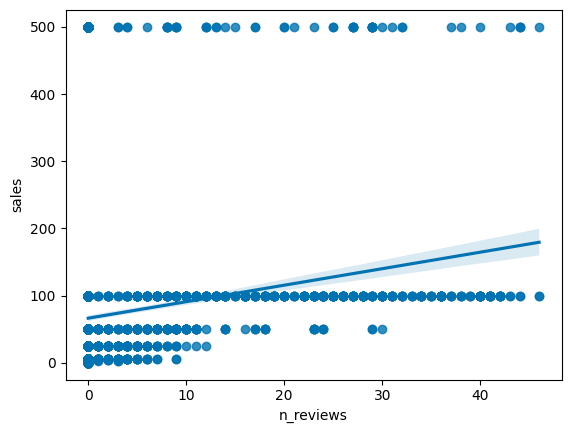

In [ ]:
sbn.regplot(data_meli, x = 'n_reviews', y = 'sales' )

## Reduced Forms

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
y1 = np.array(data_meli.sales_1.str.replace("Nuevo", "0").str.replace("mil", "000").str.strip("+ vendidos").astype(float))

In [ ]:
data_meli.columns

Index(['link', 'title', 'n_reviews', 'n_stars', 'l_tree', 'categories',
       'stock', 'new', 'sales_1', 'recommended', 'free_delivery',
       'seller_name', 'seller_link', 'seller_sales', 'ch_vec', 'n_benefits',
       'benefits', 'curr_price', 'page', 'rank', 'title_initial', 'platform',
       'devolucion_gratis', 'mercado_puntos', 'compra_protegida', 'porencia_w',
       'potencia_w'],
      dtype='object')

In [ ]:
X = data_meli[["n_reviews", "n_stars", "stock", "new", "recommended", "free_delivery", "n_benefits", "curr_price", "page", "rank", "devolucion_gratis", "mercado_puntos", "compra_protegida", "potencia_w"]]
X["recommended"] = X["recommended"] == "True"
X = np.array(X.astype(float))
X = sm.add_constant(X)

<ipython-input-342-a5295bae45f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["recommended"] = X["recommended"] == "True"


In [ ]:
X = data_meli[["stock", "new", "free_delivery", "n_benefits", "curr_price", "page", "rank"]]
X = np.array(X.astype(float))
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y1, X)

In [ ]:
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.162
Date:                Tue, 04 Jul 2023   Prob (F-statistic):              0.323
Time:                        02:19:25   Log-Likelihood:                -3885.8
No. Observations:                 472   AIC:                             7788.
Df Residuals:                     464   BIC:                             7821.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6609    671.563      0.159      0.8